In [232]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite, factorial, factorial2
from functools import lru_cache
from scipy.integrate import simpson
from scipy.signal import fftconvolve

In [146]:
def shapelet_basis(x, y, a, b, beta, xc=0.0, yc=0.0):
    """
    Compute shapelet basis function B_ab(x,y).
    """
    # Hermite polynomials
    Ha = hermite(a)
    Hb = hermite(b)

    # Normalization
    kab = 1.0 / np.sqrt(np.pi * factorial(a) * factorial(b) * (2.0 ** (a + b)))

    # Shift and scale
    x_ = (x - xc) / beta
    y_ = (y - yc) / beta

    # Basis function
    return kab * (1.0 / beta) * np.exp(-0.5 * (x_ ** 2 + y_ ** 2)) * Ha(x_) * Hb(y_)


def shapelet_coeff(image, x, y, a, b, beta, xc=0.0, yc=0.0):
    """
    Compute coefficient f_ab by integrating image * basis over x,y.
    """
    B = shapelet_basis(x[:, None], y[None, :], a, b, beta, xc, yc)
    integrand = image * B

    # Numerical integration over pixel grid
    # simpson integrates along axis
    fx = simpson(integrand, x, axis=0)
    f_ab = simpson(fx, y, axis=0)
    return f_ab

In [164]:
@lru_cache(maxsize=None)
def h(L_index: int, sum_index: int, L_factor: float):
    return factorial(L_index) * (-1) ** sum_index * (2 * L_factor) ** (L_index - 2 * sum_index) / (
            factorial(sum_index) * factorial(L_index - 2 * sum_index))


def L(l, m, n, a, b, c):
    total = 0.0
    if (l + m + n) % 2 == 1:
        return 0
    for i in range(0, l // 2 + 1):
        for j in range(0, m // 2 + 1):
            for k in range(0, n // 2 + 1):
                index_factor = int(l + m + n - 2 * (i + j + k))
                total += h(l, i, a) * h(m, j, b) * h(n, k, c) * factorial(index_factor) / factorial(
                    index_factor / 2) * (1 / 2) ** index_factor
    return total


def C(a1, a2, a3, beta_out, beta_psf, beta_in):
    nu = (beta_out ** 2 * beta_psf ** 2 * beta_in ** 2)
    pre_factor = (2 ** (a1 + a2 + a3) * np.sqrt(np.pi) * factorial(a1) * factorial(a2) * factorial(
        a3) * beta_out ** -1 * beta_psf ** -1 * beta_in ** -1) ** (-1 / 2)
    return (2 * np.pi) * (-1) ** a1 * (1j ** (a1 + a2 + a3)).real * nu * pre_factor * L(a1, a2, a3,
                                                                                        np.sqrt(2) * nu * beta_out,
                                                                                        np.sqrt(2) * nu * beta_psf,
                                                                                        np.sqrt(2) * nu * beta_in)


def P(N, beta_in, beta_psf, beta_out, p_psf):
    C_matrix = np.zeros((N + 1, N + 1, N + 1))
    for m in range(N + 1):
        for n in range(N + 1):
            for l in range(N + 1):
                C_matrix[m, n, l] = C(m, n, l, beta_out, beta_psf, beta_in)
    P4 = np.einsum('acb,lnm,cn->albm', C_matrix, C_matrix, p_psf)
    return P4

In [149]:
# PSF
def moffat(x, y, m, a):
    """
    (1+(r/a)^2)^-m
    """
    return (1+(x**2+y**2)/a**2)**(-m)

# Galaxy
def sersic(x, y, k, n):
    """
    exp[-kr^(1/n)]
    """
    return np.exp(-k*(x**2+y**2)**(1/n))

-1.9975377046288336e-17 0.0


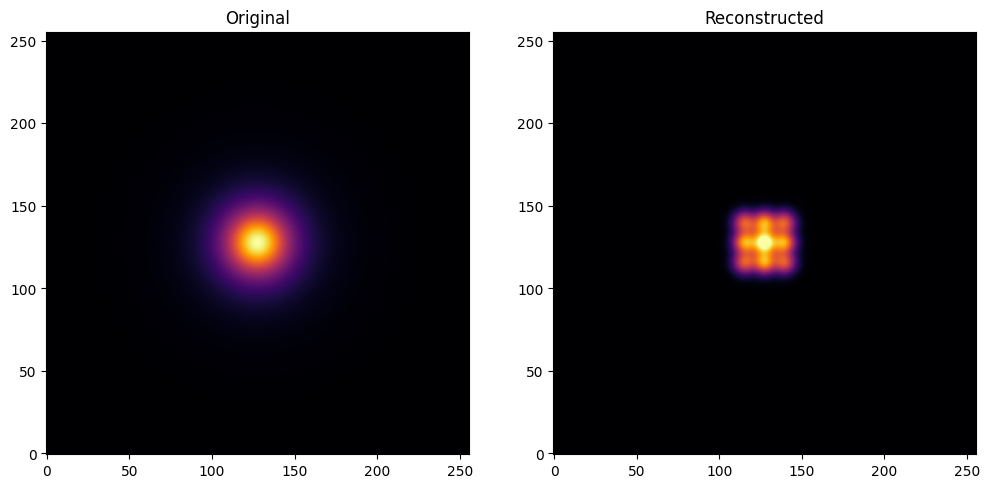

In [238]:
N = 256
x = np.linspace(-10, 10, N)
y = np.linspace(-10, 10, N)
X, Y = np.meshgrid(x, y)

image_psf = moffat(X, Y, 2, 2)

N = 4
beta_psf = 0.5

p = np.zeros((N + 1, N + 1))
reconstructed = np.zeros_like(image_psf)
total_intensity = image_psf.sum()

x_center = (X * image_psf).sum() / total_intensity
y_center = (Y * image_psf).sum() / total_intensity
print(x_center, y_center)
# Compute coefficients by projection
for n1 in range(N + 1):
    for n2 in range(N + 1):
        p[n1, n2] = shapelet_coeff(image_psf, x, y, a=n1, b=n2, beta=beta_psf, xc=x_center, yc=y_center)
        reconstructed += p[n1, n2] * shapelet_basis(X, Y, a=n1, b=n2, beta=beta_psf, xc=x_center, yc=y_center)

# --- Plot results ---
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

im0 =axs[0].imshow(image_psf, cmap="inferno", origin="lower", vmin=image_psf.min(), vmax=image_psf.max())
axs[0].set_title("Original")

im1 = axs[1].imshow(reconstructed, cmap="inferno", origin="lower", vmin=image_psf.min(), vmax=image_psf.max())
axs[1].set_title("Reconstructed")

# im2 = axs[2].imshow(image - reconstructed, cmap="inferno", origin="lower", extent=[-5, 5, -5, 5])
# axs[2].set_title("Error")

# cbar1 = fig.colorbar(im0, ax=axs[:2])

# cbar2 = fig.colorbar(im2, ax=axs[2])

plt.show()

1.4116028647004223e-18 -2.782594723242035e-17
0.03851330780525579 0.03851330780525611


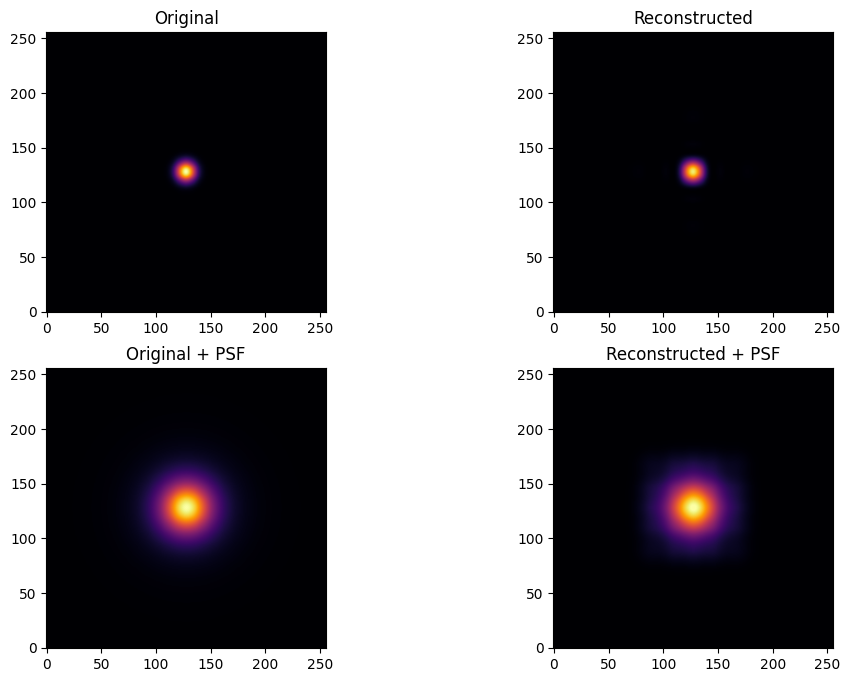

In [242]:
# --- Generate a simple test image (a Gaussian blob) ---
N = 256
x = np.linspace(-10, 10, N)
y = np.linspace(-10, 10, N)
X, Y = np.meshgrid(x, y)

image_intrinsic = sersic(X, Y, 2, 1/2)

N = 8
beta = 1

image = image_intrinsic

s = np.zeros((N + 1, N + 1))
reconstructed = np.zeros_like(image)
total_intensity = image.sum()

x_center = (X * image).sum() / total_intensity
y_center = (Y * image).sum() / total_intensity
print(x_center, y_center)
# Compute coefficients by projection
for n1 in range(N + 1):
    for n2 in range(N + 1):
        s[n1, n2] = shapelet_coeff(image, x, y, a=n1, b=n2, beta=beta, xc=x_center, yc=y_center)
        reconstructed += s[n1, n2] * shapelet_basis(X, Y, a=n1, b=n2, beta=beta, xc=x_center, yc=y_center)

# --- Plot results ---
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

im0 =axs[0,0].imshow(image, cmap="inferno", origin="lower", vmin=image.min(), vmax=image.max())
axs[0, 0].set_title("Original")

im1 = axs[0,1].imshow(reconstructed, cmap="inferno", origin="lower", vmin=image.min(), vmax=image.max())
axs[0, 1].set_title("Reconstructed")

# plt.show()

image = fftconvolve(image_intrinsic, image_psf, mode="same")

s = np.zeros((N + 1, N + 1))
reconstructed = np.zeros_like(image)
total_intensity = image.sum()

x_center = (X * image).sum() / total_intensity
y_center = (Y * image).sum() / total_intensity
print(x_center, y_center)
# Compute coefficients by projection
for n1 in range(N + 1):
    for n2 in range(N + 1):
        s[n1, n2] = shapelet_coeff(image, x, y, a=n1, b=n2, beta=beta, xc=x_center, yc=y_center)
        reconstructed += s[n1, n2] * shapelet_basis(X, Y, a=n1, b=n2, beta=beta, xc=x_center, yc=y_center)

# --- Plot results ---
# fig, axs = plt.subplots(2, 2, figsize=(12, 8))

im0 =axs[1,0].imshow(image, cmap="inferno", origin="lower", vmin=image.min(), vmax=image.max())
axs[1,0].set_title("Original + PSF")

im1 = axs[1,1].imshow(reconstructed, cmap="inferno", origin="lower", vmin=image.min(), vmax=image.max())
axs[1,1].set_title("Reconstructed + PSF")

plt.show()

In [227]:
P(N, beta, beta_psf, beta, p)**(-1)

array([[[[ 3.35019212e+00, -4.63906927e+08,  5.41172894e+00, ...,
           8.93077680e+00, -4.53002204e+08,  1.09050356e+01],
         [-4.63906926e+08,  3.57029442e+13, -7.48715448e+08, ...,
          -1.23329939e+09,  3.47685469e+13, -1.50447613e+09],
         [ 5.41172894e+00, -7.48715448e+08,  8.74177521e+00, ...,
           1.44260480e+01, -7.31115405e+08,  1.76149934e+01],
         ...,
         [ 8.93077680e+00, -1.23329939e+09,  1.44260480e+01, ...,
           2.38058754e+01, -1.20430646e+09,  2.90679082e+01],
         [-4.53002203e+08,  3.47685469e+13, -7.31115404e+08, ...,
          -1.20430646e+09,  3.38584339e+13, -1.46910716e+09],
         [ 1.09050356e+01, -1.50447613e+09,  1.76149934e+01, ...,
           2.90679082e+01, -1.46910717e+09,  3.54928318e+01]],

        [[ 4.63906927e+08,  2.69059170e+01,  1.00279320e+09, ...,
           5.51387418e+09,  2.71134467e+01, -3.27897962e+10],
         [-3.57029442e+13, -3.74880580e+09, -7.68866606e+13, ...,
          -4.11720568e

In [228]:
def F_q(a, q, beta):
    if a % 2 == 1:
        return 0
    else:
        return np.pi ** (1 / 4) * beta ** (1 / 2) * np.sqrt(factorial2(a - 1) / factorial2(a)) * (
                    (2 * q ** 2 - beta ** 2) / (2 * q ** 2 + beta ** 2)) ** (a / 2) / np.sqrt(
            1 + beta ** 2 / (2 * q ** 2))


In [229]:
q = 1
F_matrix = np.zeros(N+1)
for i in range(N+1):
    F_matrix[i] = F_q(i, q, beta)



In [230]:
F = np.einsum('abcd,a,b,cd->', P(N, beta, beta_psf, beta, p)**(-1), F_matrix, F_matrix, s)

In [231]:
print(F)

-160764.64455152978
